<h1> News Dataset Analysis </h1>

In analysing the news dataset using both the original data, as well as the n-grams generated using the python file, we aim to:
1. Clean up the data
2. Assign a better measure of importance than simply the frequency measured by the n-gram generator
3. Re-organise the data based on this new measure and using other parameters present in the original dataset such as category and date
4. Visualise the data to show the results

We will also discuss further changes that can be implemented on the data at the end of the analysis.

In [1]:
import pandas
import math
import numpy
import main
from datetime import timedelta, datetime

<h2> Clean-Up </h2>

We import all the data we wrote into an CSV file (used instead of xlsx for reasons of length that are discussed in the python code comments) for the n-gram models and check if they're read correctly. Further, we import the actual json data provided as well.

In [2]:
oneGram = pandas.read_csv('1-gram outputs.csv', index_col=0, header=0, keep_default_na=False, na_values=[''])
twoGrams = pandas.read_csv('2-gram outputs.csv', index_col=0, header=0)
origData = pandas.read_json('News_Category_Dataset_v2.json', lines=True)

In [3]:
print(oneGram.head())
print('Length: ' + str(len(oneGram)) + '\n\n')
print(twoGrams.head())
print('Length: ' + str(len(twoGrams)))

                       Frequency
a                         134348
aa                            14
aaa                            7
aaaaaaaaaaaaaaahhhhhh          1
aaaaaah                        1
Length: 84465


               Frequency
a a                   37
a aaron                1
a aawful               1
a about                1
a abstraction          1
Length: 1797575


To start the data clean-up, we remove "stop words" from the n-gram list. Stop-words are a NLP term for commonly used words like articles and prepositions that are important for reading, but have to be excluded in textual analysis due to their high frequency but low importance. In order to remove them, we use the natural language toolkit to import a list of the most commonly used stop words.

Further, we also want to remove plurals, and for that purpose we use the SnowballStemmer package inside nltk to find and remove all words with the same stem (except for one). We make this operation (for both 1-grams and 2-grams) into a function, since we need to redo the operation on other frames later.

In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [5]:
oneGram.drop(stop_words, inplace=True, errors='ignore')
print(oneGram.head())

                       Frequency
aa                            14
aaa                            7
aaaaaaaaaaaaaaahhhhhh          1
aaaaaah                        1
aaaargh                        1


In [6]:
def oneGramStemmer(oneGramFrame):
    stemmedDict = dict(zip([stemmer.stem(ind) for ind in oneGramFrame.index.tolist()], oneGramFrame.index.tolist()))
    # creating a dict automatically drops duplicate values so the list above is unique
    oneGramFrame.drop([ind for ind in oneGramFrame.index.tolist() if stemmedDict[stemmer.stem(ind)]!=ind],
                      inplace=True, errors='ignore')

oneGramStemmer(oneGram)
oneGram.sort_values(by=['Frequency'], axis=0, ascending=False, inplace=True)
print(oneGram.head())

        Frequency
photos      11375
us           9204
would        7064
could        6869
said         6812


In the 2-gram list, we again remove any phrases containing stop-words since they do not convey any additional info and the remaining word that they are combined with would already be in the 1-gram list. This reduces the size considerably and allows for more complicated operations to be performed.

The stemming part for 2-grams is a little more complicated, but essentially we separate the first and second word from the indexes into 2 separate lists. Then, we find stem words for the first word list, and piece together a unique list of 2 word strings by combining it back with the list of second words. Anything not appearing in this unique list is removed. We repeat the operation from the other side (find stem words for second word list and so on).

In [7]:
twoGrams.sort_values(by=['Frequency'], ascending=False, inplace=True)
print(twoGrams.head())

        Frequency
of the      23037
in the      20092
it s        14745
to the       9588
to be        9160


In [8]:
# this cell takes a little bit of time, but the clean up ratio is worth it!

deleter_column = []
for key in twoGrams.index.tolist():
    for stpword in stop_words:
        if (stpword+' ' in key.split(' ')[0]+' ') or (' '+stpword in ' '+key.split(' ')[-1]):
            deleter_column.append(True)
            break
        if stop_words.index(stpword) == len(stop_words)-1:
            deleter_column.append(False)

twoGrams['deleter_col']=deleter_column
twoGrams.drop(twoGrams[twoGrams['deleter_col']==True].index, inplace=True)

twoGrams.sort_values(by=['Frequency'], ascending=False, inplace=True)
twoGrams.drop('deleter_col', axis=1, inplace=True)
del deleter_column
print(twoGrams.head())

                  Frequency
white house            1568
health care            1249
climate change         1107
twitter facebook        888
york city               691


In [9]:
def twoGramStemmer(twoGramFrame):
    firstWordList = [ind.split(' ')[0] for ind in twoGramFrame.index.tolist()]
    secondWordList = [ind.split(' ')[1] for ind in twoGramFrame.index.tolist()]
    stemmedDict = dict(zip([stemmer.stem(firstWordList[ind]) + ' ' + secondWordList[ind] for ind in range(len(firstWordList))],
                           twoGramFrame.index.tolist()))
    twoGramFrame.drop([ind for ind in twoGramFrame.index.tolist()
                       if stemmedDict[stemmer.stem(ind.split(' ')[0])+' '+ind.split(' ')[1]]!=ind],
                      inplace=True, errors='ignore')
    
    # stemmed word lists are remade after reiterating over the cleaned up frame
    firstWordList = [ind.split(' ')[0] for ind in twoGramFrame.index.tolist()]
    secondWordList = [ind.split(' ')[1] for ind in twoGramFrame.index.tolist()]
    stemmedDict = dict(zip([firstWordList[ind] + ' ' + stemmer.stem(secondWordList[ind]) for ind in range(len(firstWordList))],
                           twoGramFrame.index.tolist()))
    twoGramFrame.drop([ind for ind in twoGramFrame.index.tolist() 
                       if stemmedDict[ind.split(' ')[0]+' '+stemmer.stem(ind.split(' ')[1])]!=ind],
                      inplace=True, errors='ignore')

twoGramStemmer(twoGrams)
twoGrams.sort_values(by=['Frequency'], ascending=False, inplace=True)
print(twoGrams.head())

                  Frequency
health care            1249
twitter facebook        888
york city               691
north korea             542
fox news                492


<h2> Analysis </h2>

We consider the word list to be sufficiently clean. As we can see, we have brought down the size of 1-grams to ~58,000 from the initial list of ~84,000. With 2-grams, we have done even better and brought down the list close to 200,000 from an initial list which was closer to 1.8 million. Now that we've cleaned the data set, we get down to analysis.

To find the most important words, we try to negate the effect of "filler words" that have not been cleaned with the stop words list (such as "new", "one", "time" etc). To do this, we sort the 1-gram list by the product of word length and (log of) frequency, based on the intuition that filler words are shorter and we can reduce the impact of their frequency by taking log.

This turns out to have commonality with the TF-IDF method, which isn't directly applicable here since our analysis considers document (or news headline) frequency to be incidental. The view taken is that although we may want to look at smaller slices of the data, the importance is measured on the entire timeline. So if "white house" proclamations are important at all times, we have better chances of capturing it even if we narrow down the scope of our analysis, since we use the master data sets cleaned in the operations before as our benchmark. The flip side of this, is that in case there are smaller news stories breaking on a weekly / daily basis, they would not break the threshold of importance we set.

In [10]:
oneGram['helper_col'] = oneGram.apply(lambda key: len(key.name)*math.log(key), axis=1)
oneGram.sort_values(by=['helper_col'], axis=0, ascending=False, inplace=True)
# drop everything with frequency=1 since it isn't important, and it causes the helper_col to be 0
oneGram.drop(oneGram[oneGram.Frequency==1].index, inplace=True)

We repeat the same filler word clean up for the 2-gram list. Although we could use the 1-gram list to further enhance the 2-gram filter instead of repeating the process, we tend to lose information through that method. For example, while "white" may be a low importance filler word in the 1-gram analysis, "white house" would be an important phrase in the 2-gram list. Hence, using the importance of "white" from the 1-gram analysis does not add to (and in fact, detracts from) our analysis of the 2-gram list.

In [11]:
twoGrams['helper_col'] = twoGrams.apply(lambda key: len(key.name)*math.log(key), axis=1)
twoGrams.sort_values(by=['helper_col'], axis=0, ascending=False, inplace=True)
twoGrams.drop(twoGrams[twoGrams.Frequency==1].index, inplace=True)

Now, we take the original data into consideration. Since the dataset has a category column, we can use it to enhance our analysis, along with the headlines. We measure the importance of a single word by considering headlines within a given category, and creating new 1 & 2-gram lists with them. We compare this list against the cleaned up lists from our previous operation, and drop words that don't feature in the larger list. The items that make it through this filter are added to the final dataframe.

Since this is a finance-oriented analysis, we consider weekly news to be a bigger driver of long term performance than either daily or monthly (the former being too short and the latter being too long a timeframe). We use this assumption to create a dataframe with end-of-week (Friday) dates and analyse the importance of words from the headline + short description of the week leading upto that Friday. This narrows down our scope considerably.

In [12]:
sourceDates = pandas.to_datetime(origData.date.unique())
sourceDates = [dt for dt in sourceDates if dt.weekday()==4]

categoryDataFrame = pandas.DataFrame(columns = origData.category.unique(), index = pandas.MultiIndex.from_product([[1,2], sourceDates]))
del sourceDates

In [13]:
# This cell takes extremely long to execute since it is a repetition of all the work done in the n-grams py file
# as well as some of the cleanup above and repeated multiple times for different dates and categories. Since this
# is the final step before we use the data for visualisation, it makes sense to allow for the overhead.

for dt in categoryDataFrame.index.get_level_values(1).unique():
    for cat in categoryDataFrame.columns:
        weekData =  origData[origData.date.isin([dt-timedelta(days=i) for i in range(0,5)]) & origData.category.isin([cat])]
        texts = ' '.join(weekData['headline'].tolist() + weekData['short_description'].tolist())
            
        # use our original n-grams module to create a new set of n-grams and compare them to the existing list
        twoWord = main.ngram(texts, 2, writeToFile=False, returnFrame=True)
        twoGramStemmer(twoWord)
        # make use of all the clean up done above to drop stop words, stem copies etc
        twoWord = twoWord[twoWord.index.isin(twoGrams.index)]
        twoWord = twoWord.assign(Frequency = twoGrams['helper_col'].loc[twoWord.index]).sort_values('Frequency', ascending=False)
        categoryDataFrame[cat].loc['2', dt] = twoWord.T.to_dict(orient='list')
        
        oneWord = main.ngram(texts, 1, writeToFile=False, returnFrame=True)
        oneGramStemmer(oneWord)
        oneWord = oneWord[oneWord.index.isin(oneGram.index)]
        oneWord = oneWord.assign(Frequency = oneGram['helper_col'].loc[oneWord.index]).sort_values('Frequency', ascending=False)
        categoryDataFrame[cat].loc['1', dt] = oneWord.T.to_dict(orient='list')

<h2> Visualisation </h2>

The data as stored in the categoryDataFrame consists of the words and their (overall) importance within each category on a weekly basis. To visualise this, we construct a word cloud using a package found on github called <a href="https://github.com/amueller/word_cloud">word_cloud</a>.

We give parameters that can be edited to construct the cloud:
- weeksOf: Friday dates of every week to be considered for constructing the word cloud
- cats: categories to be displayed. Each category gets its own word cloud since they are mostly unrelated and have few common words of importance
- no_of_1grams, no_of_2grams: No of words to display in the 1-gram and 2-gram word clouds (again, each is displayed separately). If given a value of 0, it displays all possible words in the list.

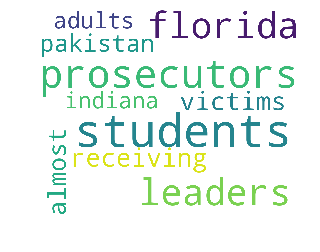

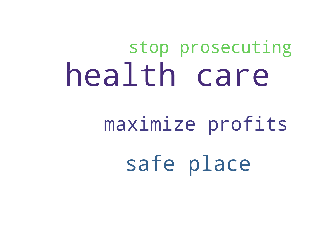

In [16]:
import wcloud

weeksOf = ['2018-05-25', '2018-05-18']
cats = ['CRIME']
no_of_1grams = 10
no_of_2grams = 10

for ct in cats:
    oneGramDict = categoryDataFrame[ct].loc['1', weeksOf[0]]
    twoGramDict = categoryDataFrame[ct].loc['2', weeksOf[0]]
    for i in range(1,len(weeksOf)):
        oneGramDict.update(categoryDataFrame[ct].loc['1', weeksOf[i]])
        twoGramDict.update(categoryDataFrame[ct].loc['2', weeksOf[i]])
    
    if no_of_1grams==0 or no_of_1grams>len(oneGramDict):
        no_of_1grams = len(oneGramDict)
    if no_of_2grams==0 or no_of_2grams>len(twoGramDict):
        no_of_2grams = len(twoGramDict)
    
    oneGramDict = dict(zip(list(oneGramDict.keys())[:no_of_1grams], [item for sublist in list(oneGramDict.values())[:no_of_1grams] for item in sublist]))
    twoGramDict = dict(zip(list(twoGramDict.keys())[:no_of_2grams], [item for sublist in list(twoGramDict.values())[:no_of_2grams] for item in sublist]))
        
    wcloud.gen_wcloud(oneGramDict)
    wcloud.gen_wcloud(twoGramDict)

<h2> Further Improvements </h2>

The analysis presented here is extremely basic for a corpus of news. Although the code itself is scalable, the analysis can be done in many other ways. Some examples:

1. Based on the target use-case (equities / rates / commodities), we can prune the word list to remove all irrelevant words and make it more focussed.
2. With some time series analysis based on the news corpus (eg does S&P move more when "China" is mentioned in the news), we can focus the list to become an effective trading strategy tool.
3. The visualisation presented can be done of a GUI to make it user friendly.
4. The code can be optimised to run parallely since many of the operations are repeated separately on the 1-gram and 2-gram dataframes and hence, thread friendly.

With some more knowledge of NLP techniques, this basic analysis can be compressed into much fewer lines of code, and enhanced with algorithms already established by dedicated NLP engineers. Unfortunately, I do not have the advantage of having dealt with NLP before, and need to read a few technical papers before being able to decide the right algorithms to use for this analysis.

Further study is definitely necessary to make improvements, and updates will be available <a href="https://github.com/anirudhramesh/n-gram-model">here</a>.